# Coin Flip Example

How do you update your belief based on new data? In the following example, vary n_trials (size of the dataset) and see how the distribution becomes more and more narrow, eventually converging to the true ratio of heads to tails.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats

# Define the data
dist = stats.beta
n_trials = 50
data = stats.bernoulli.rvs(0.5, size = n_trials)
x = np.linspace(0, 1, 100)

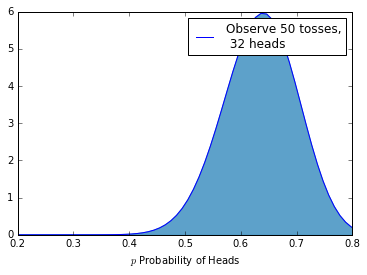

In [2]:
plt.xlabel("$p$ Probability of Heads")
heads = data.sum()
y = dist.pdf(x, 1 + heads, 1 + n_trials - heads)
plt.plot(x, y, label = "Observe %d tosses,\n %d heads" % (n_trials, heads))
plt.fill_between(x, 0 ,y, color="#348ABD", alpha=0.8)
plt.xlim(0.2, 0.8)
plt.legend()

# Probability Distributions

## Types of Random Variables

1. $Z$ is discrete
1. $Z$ is continuous
1. $Z$ is mixed

## Discrete Case

### Poisson Distribution

$P(Z=k) = \frac{\lambda^{k}e^{-\lambda}}{k!}, k = 0, 1, 2,..$

$E[Z|\lambda] = \lambda$


## Continuous Case

### Exponential Distribution

$f_{z}(Z|\lambda) = \lambda e ^ {-\lambda z}, z \geq 0$ 

$E[Z|\lambda] = \dfrac{1}{\lambda}$

# Introduction to PyMC

This is done using the text messaging data. First, let's read in the data:

<Container object of 74 artists>

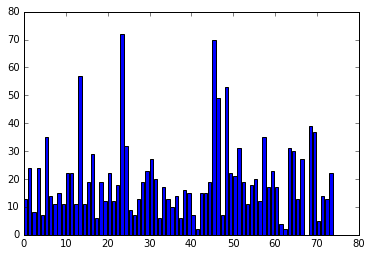

In [3]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data)

We are interested in seeing if the volume of text messages increased after a certain point. For this, we consider three parameters:

1. $\tau$ - Number of days at which behavior changes
1. $\lambda_1$ - Poisson mean of text messages before switch
1. $\lambda_2$ - Poisson mean of text messages after switch

Let the $\lambda$s have an exponential distribution with *hyper parameter* $\alpha$.

Now let's model all this using PyMC.

In [4]:
import pymc as pm
alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower = 0, upper = n_count_data)

In [5]:
@pm.deterministic
def lambda_(tau = tau, lambda_1 = lambda_1, lambda_2 = lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [6]:
observation = pm.Poisson("obs", lambda_, value = count_data, observed = True)
model = pm.Model([observation, tau, lambda_1, lambda_2])
mcmc = pm.MCMC(model)
mcmc.sample(70000, 10000, 1)

 [-----------------100%-----------------] 70000 of 70000 complete in 17.0 sec

In [7]:
lambda_1_samples = mcmc.trace("lambda_1")[:]
lambda_2_samples = mcmc.trace("lambda_2")[:]
tau_samples = mcmc.trace("tau")[:]


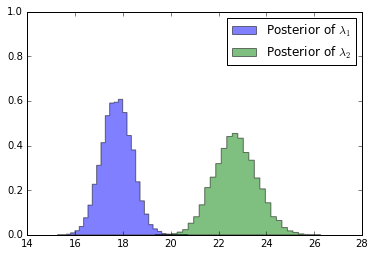

In [8]:
plt.hist(lambda_1_samples, histtype="stepfilled", bins = 30, alpha = 0.5, normed = True, label = "Posterior of $\lambda_1$");
plt.hist(lambda_2_samples, histtype="stepfilled", bins = 30, alpha = 0.5, normed = True, label = "Posterior of $\lambda_2$");
plt.ylim(0, 1);
plt.legend();

(0, 74)

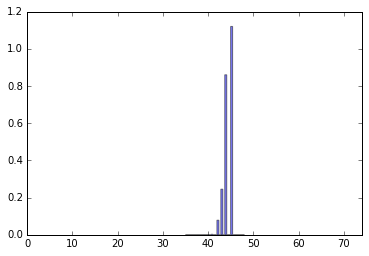

In [9]:
plt.hist(tau_samples, histtype="stepfilled", bins = 30, alpha = 0.5, normed = True, label = "Posterior of $\tau$");
plt.xlim(0, n_count_data)

### Quantities of Interest

In [12]:
lambda_1_samples.mean()


17.753132205341064

In [13]:
lambda_2_samples.mean()

22.709758747033938

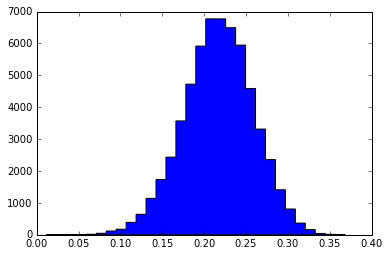

In [19]:
perc_increase = 1 - lambda_1_samples/lambda_2_samples
perc_increase.mean()
plt.hist(perc_increase, histtype = "stepfilled", bins = 30);

In [20]:
ix = tau_samples < 45
lambda_1_samples[ix].mean()

17.748900741719112